# Convolutional Neural Networks on CIFAR-10

This notebook performs classification on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The following concepts are explored:

- Manual definition of a CNN similar to LeNet to test classification.
- Data augmentation for a better generalization.
- Transfer learning for a better classification.
- Training on a CUDA device, Jetson Nano per SSH.

In order to use these examples, we need to install Pytorch in out environment (eg., by using Anaconda):

```bash
conda create -n myenv python=3.6
source activate myenv
conda install opencv-python matplotlib numpy pillow jupyter scipy pandas
conda install pytorch torchvision -c pytorch
# I had some issues with numpy and torch
pip uninstall numpy
pip uninstall mkl-service
pip install numpy
pip install mkl-service
```

I used my `dlnd` environment.

For a more detailed guide on Deep Learning and its implementation and use with Pytorch, have a look at my complete repository on that topic:

[deep_learning_udacity](https://github.com/mxagar/deep_learning_udacity)

I have used several source files to compile this project, mainly from Udacity:

[deep-learning-v2-pytorch](https://github.com/mxagar/deep-learning-v2-pytorch)

- `/convolutional-neural-networks/cifar-cnn/`
- `/transfer-learning/`

### Overview of Contents

1. [Imports and Test for CUDA](#1.-Imports-and-Test-for-CUDA)
2. [Load and Augment the Data](#2.-Load-and-Augment-the-Data)

    - 2.1 Visualize the Dataset

3. [Define the CNN Manually](#3.-Define-the-CNN-Manually)

    - 3.1 Loss Function and Optimizer

4. [Train the Network](#4.-Train-the-Network)

    - 4.1 Load the Best Network

5. [Evaluate the Network](#5.-Evaluate-the-Network)

    - 5.1 Visualize Some Results

## 1. Imports and Test for CUDA

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## 2. Load and Augment the Data

The dataset is automatically downloaded to the local folder `data`. In order to increase invariance and generalization, we augment the data.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### 2.1 Visualize the Dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

/Users/mxagar/opt/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


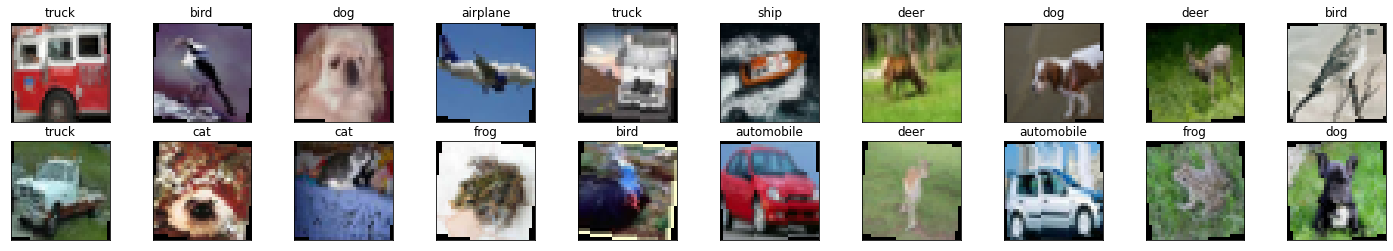

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## 3. Define the CNN Manually

Useful guidelines:

- Usual architecture: 2-4 `Conv2d` with `MaxPool2d`in-between so that the size is halved; at the end 1-3 fully connected layers with dropout in-between to avoid overfitting.
- Recall that an image has the shape `B x W x H x D`. The bacth size `B` is usually not used during the network programming, but it's there, even though we feed one image per batch!
- In the convolutions:
    - Prefer small 3x3 filters; use odd numbers in any case.
    - Use padding so that the size of the image is preserved! That means taking `padding=floor(F/2)`.
    - Recall the size change formula: `W_out = (W_in + 2P - F)/S + 1`.
- Use `relu()` activation after each convolution, but not after max-pooling.
- If we use a unique decreasing factor in `MaxPool2d`, it's enough defining a unique `MaxPool2d`.
- The typical max-pooling is the one which halvens the size: `MaxPool2d(2,2)`.
- Before entering the fully connected or linear layer, we need to flatten the feature map:
    - In the definition of `Linear()`: we need to compute the final volume of the last feature map set. If we preserved the sized with padding it's easy; if not, we need to apply the formula above step by step.
    - In the `forward()` method: `x = x.view(x.size(0), -1)`; `x.size(0)`is the batch size, `-1` is the rest. 
- If we use `CrossEntropyLoss()`, we need to return the `relu()` output; if we return the `log_softmax()`, we need to use the `NLLLoss()`. `CrossEntropy() == log_softmax() + NLLLoss()`.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### 3.1 Loss Function and Optimizer

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 4. Train the Network

The validation split is tested after each epoch. The model with the smallest validation loss is saved.

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

### 4.1 Load the Best Network

Take into account that we need to map the weights to the CPU if the network was trained on the GPU but we are loading it to the CPU!

In [9]:
if train_on_gpu:
    model.load_state_dict(torch.load('model_augmented.pt'))
else:
    model.load_state_dict(torch.load('model_augmented.pt',map_location=torch.device('cpu')))

## 5. Evaluate the Network

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.722280

Test Accuracy of airplane: 76% (769/1000)
Test Accuracy of automobile: 80% (809/1000)
Test Accuracy of  bird: 55% (556/1000)
Test Accuracy of   cat: 58% (582/1000)
Test Accuracy of  deer: 79% (791/1000)
Test Accuracy of   dog: 64% (646/1000)
Test Accuracy of  frog: 80% (804/1000)
Test Accuracy of horse: 80% (806/1000)
Test Accuracy of  ship: 89% (894/1000)
Test Accuracy of truck: 86% (869/1000)

Test Accuracy (Overall): 75% (7526/10000)


### 5.1 Visualize Some Results

/Users/mxagar/opt/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


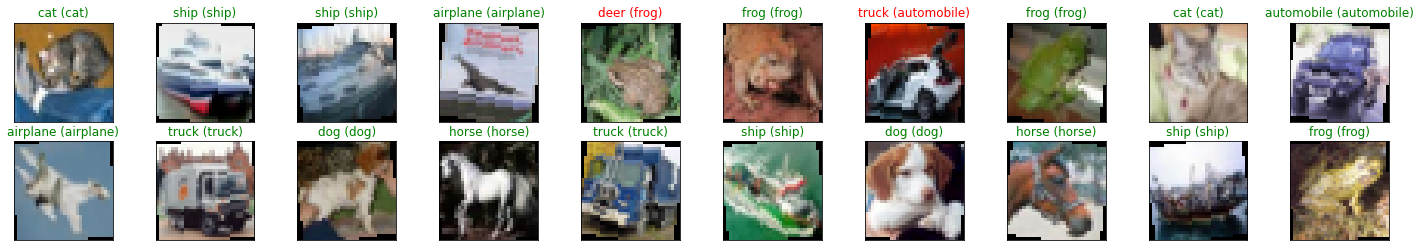

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))